Kaggle competition: Digit Recognizer  
https://www.kaggle.com/c/digit-recognizer  

Accuracy: 99.542%

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from functools import partial

print(tf.__version__)
print(tf.executing_eagerly())

2.2.0
True


In [ ]:
train = np.loadtxt('/kaggle/input/digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/kaggle/input/digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [ ]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (42000, 785)
Test shape: (28000, 784)


In [ ]:
train_label = train[:, 0]
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

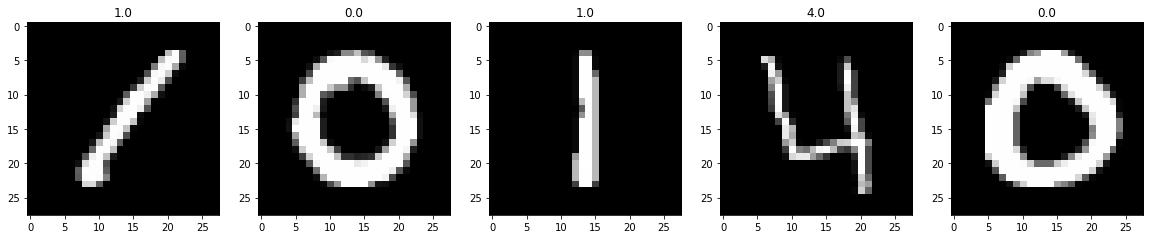

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [ ]:
np.unique(train_label)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

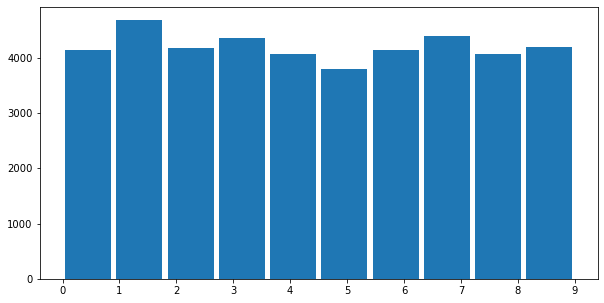

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.hist(train_label, align='mid', rwidth=0.9)
plt.xticks(np.unique(train_label))
plt.show();

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_img, train_label, test_size=0.2, random_state=42)

In [ ]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')

x_train shape: (33600, 28, 28, 1)
y_train shape: (33600,)
x_val shape: (8400, 28, 28, 1)
y_val shape: (8400,)


In [ ]:
epochs = 50
batch_size = 128
validation_steps = 10000

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2),
                                 input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=3,
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.Conv2D(filters=128,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=128,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.Conv2D(filters=192,
                                 kernel_size=(3,3),
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=192,
                                 kernel_size=(5,5),
                                 padding='same',
                                 activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation=partial(tf.nn.leaky_relu, alpha=1e-2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


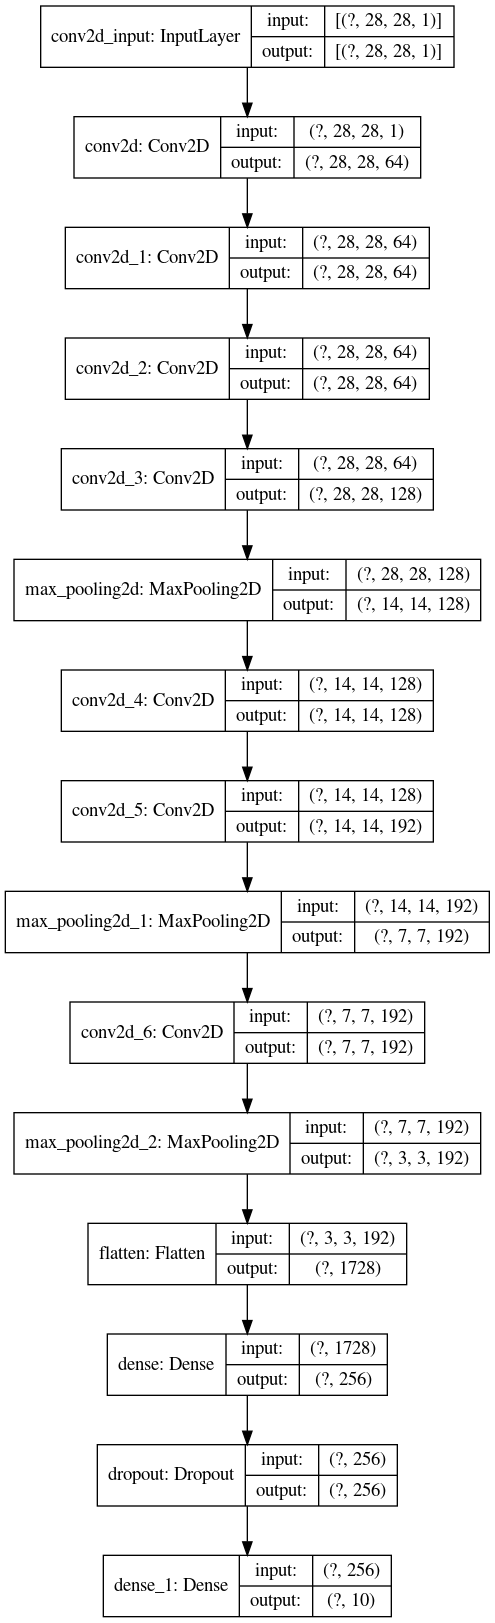

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 192)       2

In [ ]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                           samplewise_center=False,
                                                           featurewise_std_normalization=False,
                                                           samplewise_std_normalization=False,
                                                           zca_whitening=False,
                                                           rotation_range=10,
                                                           zoom_range=0.1,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           horizontal_flip=False,
                                                           vertical_flip=False)

In [ ]:
callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                patience=1,
                                                verbose=2,
                                                factor=0.5,
                                                min_lr=1e-7)

In [ ]:
y_train_labels = tf.keras.utils.to_categorical(y_train)
y_val_labels = tf.keras.utils.to_categorical(y_val)

In [ ]:
print(f'Unique values y_train_labels: {np.unique(y_train_labels)}')
print(f'Unique values y_val_labels: {np.unique(y_val_labels)}')

Unique values y_train_labels: [0. 1.]
Unique values y_val_labels: [0. 1.]


In [ ]:
train_aug = data_aug.flow(x_train, y_train_labels, batch_size=batch_size)
val_aug = data_aug.flow(x_val, y_val_labels, batch_size=batch_size)

In [ ]:
hist = model.fit(train_aug,
                 steps_per_epoch=x_train.shape[0]//batch_size,
                 epochs=epochs,
                 validation_data=val_aug,
                 validation_steps=validation_steps//batch_size,
                 callbacks=[callback])

Epoch 1/50
262/262 [==============================] - 18s 68ms/step - loss: 0.6538 - accuracy: 0.7986 - val_loss: 0.1418 - val_accuracy: 0.9576 - lr: 1.0000e-04
Epoch 2/50
262/262 [==============================] - 16s 62ms/step - loss: 0.1546 - accuracy: 0.9530 - val_loss: 0.0769 - val_accuracy: 0.9767 - lr: 1.0000e-04
Epoch 3/50
262/262 [==============================] - 16s 61ms/step - loss: 0.1085 - accuracy: 0.9669 - val_loss: 0.0641 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 4/50
262/262 [==============================] - 18s 68ms/step - loss: 0.0883 - accuracy: 0.9734 - val_loss: 0.0511 - val_accuracy: 0.9843 - lr: 1.0000e-04
Epoch 5/50
262/262 [==============================] - 16s 62ms/step - loss: 0.0704 - accuracy: 0.9799 - val_loss: 0.0432 - val_accuracy: 0.9874 - lr: 1.0000e-04
Epoch 6/50
262/262 [==============================] - 17s 65ms/step - loss: 0.0604 - accuracy: 0.9808 - val_loss: 0.0454 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 7/50
262/262 [==============

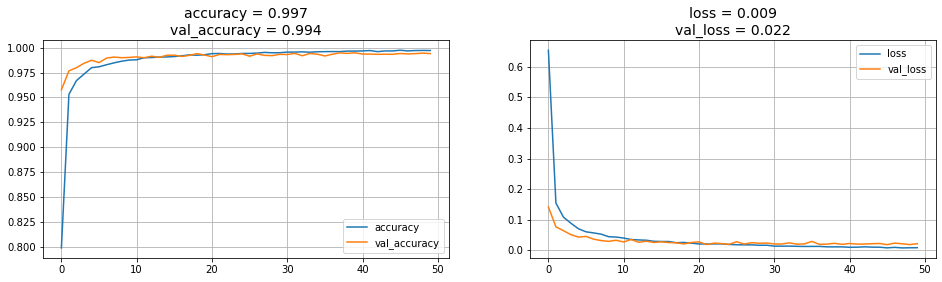

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(('accuracy = {}\nval_accuracy = {}'.format(round(hist.history['accuracy'][-1],3), 
                                                   round(hist.history['val_accuracy'][-1],3))), fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss = {}\nval_loss = {}'.format(round(hist.history['loss'][-1],3), 
                                           round(hist.history['val_loss'][-1],3))), fontsize=14)
plt.grid(True)
plt.show();

In [ ]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       816
         1.0       0.99      1.00      1.00       909
         2.0       0.99      1.00      1.00       846
         3.0       1.00      1.00      1.00       937
         4.0       1.00      0.99      0.99       839
         5.0       1.00      0.99      1.00       702
         6.0       1.00      0.99      1.00       785
         7.0       1.00      1.00      1.00       893
         8.0       0.99      1.00      0.99       835
         9.0       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       1.00      0.99      0.99      8400
weighted avg       1.00      0.99      0.99      8400



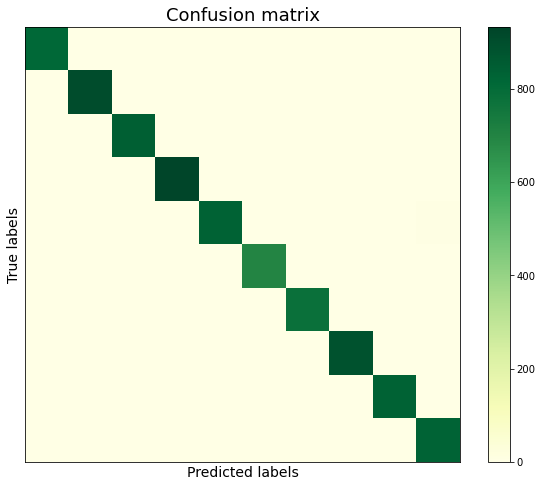

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='YlGn')
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix', fontsize=18)
plt.colorbar()
plt.show()

In [ ]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

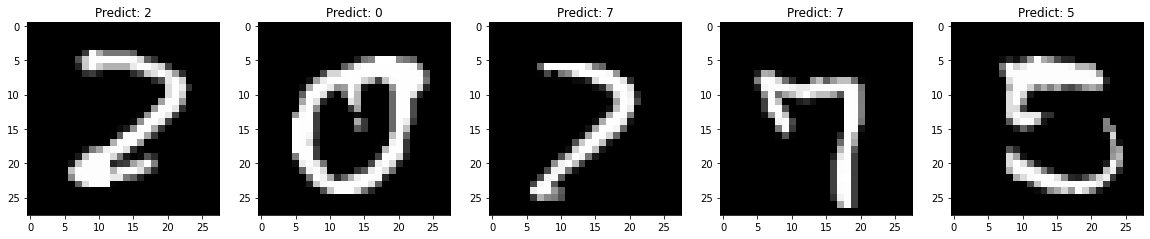

In [ ]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(test_img)), 5)
img_prediction = zip(test_img[indices], y_pred_test_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('Predict: %d' % pred);

In [ ]:
import pandas as pd

submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission['Label'] = y_pred_test_labels.astype(int)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [ ]:
submission.to_csv('submission.csv', index=False, header=True)